# Notebook for generating transition recommendations for validation

In [429]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm 
from time import time

import career_causeways.compare_nodes_utils as compare_nodes_utils
import career_causeways.load_data as load_data
import career_causeways.transitions_utils as trans_utils
find_closest = compare_nodes_utils.find_closest

import umap
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from scipy.spatial.distance import pdist, squareform

In [430]:
import regex as re

In [431]:
# Load classes that facilitate access to different data
data_folder = '../../data/'
outputs_folder = ''

data = load_data.Data(data_folder)
sim = load_data.Similarities(data_folder)
comp_features = trans_utils.CompareFeatures(data_folder)

# Skills description embeddings
embeddings = np.load(data_folder + 'interim/embeddings/embeddings_skills_description_SBERT.npy')


In [432]:
# # Occupations and their features
# data.occ.info()

# 1. All safe and desirable transitions from high-risk occupations

## 1.1 Find the transitions

In [4]:
# Extract the IDs for high-risk occupations (note that the original label for these was 'Very high risk')
high_risk_occ = data.occ_top[data.occ_top.risk_cat_label == 'Very high risk']
high_risk_ids = high_risk_occ.id.to_list()
high_risk_occ.sample(3)

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_title,risk,prop_bottleneck_tasks,prop_phys_bottleneck_tasks,risk_std,...,is_top_level,annual_gross_pay,total_paid_hours,employment_count,employment_rate,level_1,level_2,remote_labor_index,covid_score,physical_proximity
1074,1074,http://data.europa.eu/esco/occupation/59bce29f...,tutor,2359,25-3099.02,tutors,3.604661,0.449060,0.237389,0.440981,...,True,21865.956000,27.173290,12801.185185,0.000398,6,29,NaN,NaN,0.8075
2700,2700,http://data.europa.eu/esco/occupation/e93b3b49...,personal property appraiser,3315,13-2021.01,assessors,3.581750,0.429715,0.044397,0.341756,...,True,30599.993865,35.068158,22457.913043,0.000699,1,7,0.684211,0.426121,0.5750
1348,1348,http://data.europa.eu/esco/occupation/7153a12d...,ground steward/ground stewardess,4221,43-4181.00,reservation and transportation ticket agents a...,3.620310,0.364429,0.298460,0.263428,...,True,18336.107735,30.327475,56870.437500,0.001769,2,11,0.384615,0.706018,0.8100


In [5]:
assert(len(high_risk_ids)==217)

In [6]:
# Find all transitions pertaining to these occupations
all_high_risk_trans = trans_utils.get_transitions(data, sim, id_to_check=high_risk_ids)


Finding all transitions... Done!
This took 2.60 seconds.


In [7]:
# Select all safe and desirable transitions
# (use the definition of safe and desirable = not in the "Very high risk" category)
trans_df = all_high_risk_trans[all_high_risk_trans.is_safe_desirable]
len(trans_df)

4813

## 1.2 Prepare the output table to share with validators 

For each row (i.e. 1 transition), we provide:
- ID, label, and the description of the origin occupation
- ID, label, and the description of the destination occupation

- Top-10 perfectly and partially matched skills
- Top-10 unmatched skills

### Set up the parameters!

In [43]:
# Semantic similarity threshold below which we call the pairwise skill match a skills gap (i.e. "unmatched")
MATCH_THRESHOLD = 0.80 

# Max number of matched skills or "unmatched" skills gaps
N_MAX = 10

# Output file name
file_name = 'Transitions_for_1715_All_high_risk_FIXED.csv'

# Test mode generates a couple of transitions
TEST_MODE = False


In [44]:
# Take a smaller sample
# trans_df = trans_df.sample(50)

In [45]:
k = 0

perfect_matches = []
partial_matches = []
skills_gaps = []

for j, row in tqdm(trans_df.iterrows(), total=len(trans_df)):
    
    # Origin job
    job_i = row.origin_id
    
    # Destination job
    job_j = row.destination_id
    
    # Get pairwise skills matches
    # (Note: this is fairly slow - going forward, we should just generate and store all these tables)
    compare_skills = trans_utils.show_skills_overlap(job_i, job_j, data, sim, embeddings, verbose=False)
    
    # Skills above the "skills gap" thershold
    matched_skills = compare_skills[compare_skills.similarity > MATCH_THRESHOLD].iloc[0:N_MAX]
    
    # Generate strings with the perfect and partial matches
    perfect_matches.append("; ".join(matched_skills[matched_skills.similarity==1].destination_skill.to_list()))
    partial_matches.append("; ".join(matched_skills[matched_skills.similarity<1].destination_skill.to_list()))
    
    # Generate string with skills gaps ("unmatched" skills)
    skills_gaps.append("; ".join(compare_skills[compare_skills.similarity<=MATCH_THRESHOLD].sort_values(
        'similarity', ascending=True).reset_index().iloc[0:N_MAX].destination_skill.to_list()))
    
    k += 1
    if TEST_MODE:
        if k == 2:
            break

In [46]:
# Create the final output dataframe
# This is where you can add more information about the transitions if necessary (e.g. similarities)
# Also, you can use merge with data.occ[[..]] to add more descriptors about each occupation
output_df = trans_df[['origin_id', 'origin_label', 'destination_id', 'destination_label']].copy()


if TEST_MODE:
    output_df = output_df.iloc[0:2]

output_df = output_df.merge(data.occupations[['id', 'description']],
                            left_on='origin_id', right_on='id', how='left')

output_df = output_df.rename(columns={'description': 'origin_description'})
output_df = output_df.drop('id', axis=1)

output_df = output_df.merge(data.occupations[['id', 'description']],
                            left_on='destination_id', right_on='id', how='left')

output_df = output_df.rename(columns={'description': 'destination_description'})
output_df = output_df.drop('id', axis=1)

output_df['perfectly_matched_skills'] = perfect_matches
output_df['partially_matched_skills'] = partial_matches
output_df['unmatched_skills'] = skills_gaps

output_df = output_df[[
    'origin_id', 'origin_label', 'origin_description',
    'destination_id', 'destination_label', 'destination_description',
    'perfectly_matched_skills', 'partially_matched_skills', 'unmatched_skills']]


In [47]:
output_df

,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,unmatched_skills
0,29,legal guardian,Legal guardians legally assist and support min...,2867,recreational therapist,Recreational therapists offer treatment to per...,listen actively,,maintain healthcare user data confidentiality;...
1,29,legal guardian,Legal guardians legally assist and support min...,1036,social counsellor,Social counsellors provide support and guidanc...,listen actively; maintain the trust of service...,encourage counselled clients to examine themse...,reflexion; perform therapy sessions; demonstra...
2,29,legal guardian,Legal guardians legally assist and support min...,2877,social pedagogue,"Social pedagogues provide care, support, and e...",apply person-centred care; support children's ...,support the positiveness of youths; adolescent...,undertake continuous professional development ...
3,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,observe confidentiality; communicate by teleph...
4,29,legal guardian,Legal guardians legally assist and support min...,1803,special educational needs teacher,Special educational needs teachers work with a...,disability care; assess the development of you...,assist children with special needs in educatio...,special needs learning equipment; observe stud...
...,...,...,...,...,...,...,...,...,...
4808,2937,demographer,Demographers study a variety of parameters rel...,460,data scientist,Data scientists find and interpret rich data s...,execute analytical mathematical calculations; ...,design database scheme; data mining; interpret...,normalise data; information extraction; resour...
4809,2937,demographer,Demographers study a variety of parameters rel...,2885,user experience analyst,User experience analysts assess client interac...,,report analysis results; conduct quantitative ...,measure customer feedback; human-computer inte...
4810,2937,demographer,Demographers study a variety of parameters rel...,1239,market research analyst,Market research analysts collect the informati...,perform market research; statistics,,marketing mix; analyse consumer buying trends;...
4811,2937,demographer,Demographers study a variety of parameters rel...,1610,mineralogist,"Mineralogists study the composition, structure...",scientific research methodology; apply scienti...,process data; operate scientific measuring equ...,operate microscope; implement mineral processe...


## 1.3 Export

In [48]:
output_df.to_csv(outputs_folder + file_name, index=False)


In [49]:
len(output_df)

4813

In [50]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4813 entries, 0 to 4812
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   origin_id                 4813 non-null   int64 
 1   origin_label              4813 non-null   object
 2   origin_description        4813 non-null   object
 3   destination_id            4813 non-null   int64 
 4   destination_label         4813 non-null   object
 5   destination_description   4813 non-null   object
 6   perfectly_matched_skills  4813 non-null   object
 7   partially_matched_skills  4813 non-null   object
 8   unmatched_skills          4813 non-null   object
dtypes: int64(2), object(7)
memory usage: 376.0+ KB


## 1.4 Sanity check

In [51]:
output_df_sample = output_df.sample()
output_df_sample

,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,unmatched_skills
2277,1348,ground steward/ground stewardess,Ground stewards and ground stewardesses assist...,732,hotel porter,Hotel porters welcome guests to accommodation ...,assist clients with special needs; maintain cu...,handle delivered packages,comply with food safety and hygiene; greet gue...


In [52]:
print(output_df_sample.perfectly_matched_skills.iloc[0].split(';'))
print('---')
print(output_df_sample.partially_matched_skills.iloc[0].split(';'))
print('---')
print(output_df_sample.unmatched_skills.iloc[0].split(';'))

['assist clients with special needs', ' maintain customer service']
---
['handle delivered packages']
---
['comply with food safety and hygiene', ' greet guests', ' handle guest luggage']


In [53]:
trans_utils.show_skills_overlap(output_df_sample.origin_id.values[0],
                                output_df_sample.destination_id.values[0],
                                data, sim,
                                embeddings,
                                skills_match='optional',
                                verbose=True)


from ground steward/ground stewardess to hotel porter
--------
6/6 destination skills matched
NLP-adjusted overlap = 0.34 (total combined similarity: 0.37)


,origin_skill_id,origin_skill,destination_skill_id,destination_skill,similarity,score
0,9640,assist clients with special needs,9640,assist clients with special needs,1.000000,0.998
1,6288,maintain customer service,6288,maintain customer service,1.000000,0.998
2,2818,process booking,11855,handle delivered packages,0.805327,0.038
3,3880,assist VIP guests,13054,handle guest luggage,0.738448,0.001
4,3988,manage the customer experience,2052,greet guests,0.724222,0.001
5,1809,maintain relationship with customers,832,comply with food safety and hygiene,0.706303,0.000


## 1.5 Check that unmatched skills don't intersect with other skills

In [506]:
outputs_df = pd.read_csv('Transitions_for_1715_All_high_risk.csv')

In [507]:
outputs_fixed_df = pd.read_csv('Transitions_for_1715_All_high_risk_FIXED.csv')

In [508]:
j = 2762
print(outputs_df.loc[j].perfectly_matched_skills)
print('--')
print(outputs_df.loc[j].partially_matched_skills)
print('--')
outputs_df.loc[j].unmatched_skills

manage budgets
--
ensure inspections of facilities; make health, safety and environment assessments; adhere to organisational guidelines; manage manufacturing facilities; liaise with managers
--


'manage space utilisation; electrical power safety regulations; plan buildings maintenance work; supply chain management; ensure equipment availability; plan health and safety procedures; carry out energy management of facilities; monitor contractor performance; supervise work; liaise with managers'

In [509]:
def check_unmatched_skills(outputs_df):
    
    wrong_rows = []
    total_matched = []

    for j, row in outputs_df.iterrows():
        if type(row.perfectly_matched_skills)==str:
            s1 = [x.strip() for x in row.perfectly_matched_skills.split(';') if x!='']
        else:
            s1 = set() 
        if type(row.partially_matched_skills)==str:
            s2 = [x.strip() for x in row.partially_matched_skills.split(';') if x!='']
        else:
            s2 = set()
        if type(row.unmatched_skills)==str:
            s3 = [x.strip() for x in row.unmatched_skills.split(';') if x!='']
        else:
            s3 = set()    
        wrong_rows.append(len(set(s1).union(set(s2)).intersection(set(s3))))
    #     total_matched.append(len(s1) + len(s2))
    
    outputs_df_wrong = outputs_df.copy()
    outputs_df_wrong['n_wrong'] = wrong_rows
    return outputs_df_wrong
    

In [510]:
outputs_df_wrong = check_unmatched_skills(outputs_df)
print(np.sum(outputs_df_wrong.n_wrong!=0))

df = check_unmatched_skills(outputs_fixed_df)
print(np.sum(df.n_wrong!=0))

1869
0


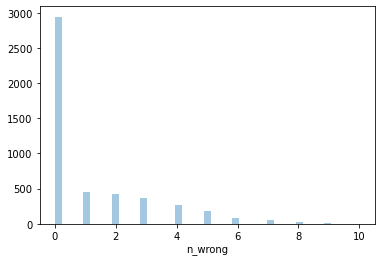

In [511]:
sns.distplot(outputs_df_wrong.n_wrong,kde=False)
plt.show()

In [512]:
# sns.distplot(outputs_df[outputs_df_wrong.n_wrong==0].similarity, kde=True)
# sns.distplot(outputs_df[outputs_df_wrong.n_wrong!=0].similarity, kde=True)
# plt.show()

In [513]:
outputs_df_wrong['CORRECT'] = False
outputs_df_wrong.loc[outputs_df_wrong.n_wrong==0, 'CORRECT'] = True

In [514]:
df = outputs_df_wrong.copy()
df = df[['origin_id', 'origin_label', 'destination_id', 'destination_label', 'CORRECT']]
# df = df.drop('n_wrong', axis=1)
df.to_csv('Transitions_for_1715_All_high_risk_HIGHLIGHTED.csv', index=False)

In [515]:
(outputs_df_wrong['CORRECT']==False).sum()

1869

### Data to re-validate

In [442]:
data_to_revalidate = outputs_fixed_df[outputs_df_wrong.n_wrong!=0]
len(data_to_revalidate)

1869

In [443]:
data_to_revalidate.to_csv('Transitions_for_1715_All_high_risk_REVALIDATE.csv', index=False)

In [444]:
outputs_df_wrong.sample(5)

,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,unmatched_skills,n_wrong
4594,2878,metrologist,Metrologists study and practice the science of...,953,political scientist,Political scientists study political behaviour...,apply scientific methods; scientific research ...,report analysis results,government policy; government policy implement...,3
3544,2027,medical sales representative,Medical sales representatives promote and sell...,1746,travel agency manager,Travel agency managers are in charge of managi...,manage budgets; perform market research,implement marketing strategies; negotiate supp...,monitor financial accounts; maximise sales rev...,0
1727,1067,insurance agency manager,Insurance agency managers coordinate and overs...,2167,business developer,\nBusiness developers strive to improve the ma...,financial analysis; liaise with managers,apply business acumen; business analysis; stud...,expand store regional presence; carry out sale...,5
2378,1426,orthoptist,Orthoptists diagnose and treat anomalies of bi...,1049,clinical perfusion scientist,Clinical perfusion scientists operate heart-l...,apply health sciences; communicate effectively...,NaN,clinical perfusion; resuscitation; operate bre...,3
2213,1290,office clerk,Office clerks are responsible for performing c...,1011,advertising assistant,Advertising assistants provide support in all ...,file documents; use different communication ch...,identify customer's needs; use IT tools,develop creative ideas; advertising techniques...,4


In [455]:
j = 2762
print(data_to_revalidate.loc[j].perfectly_matched_skills)
print('--')
print(data_to_revalidate.loc[j].partially_matched_skills)
print('--')
data_to_revalidate.loc[j].unmatched_skills

manage budgets
--
ensure inspections of facilities; make health, safety and environment assessments; adhere to organisational guidelines; manage manufacturing facilities; liaise with managers
--


'manage space utilisation; electrical power safety regulations; plan buildings maintenance work; supply chain management; ensure equipment availability; plan health and safety procedures; carry out energy management of facilities; monitor contractor performance; supervise work'

# 2. Second batch of transitions for validation

For the second batch, we take a
1. Uniform sample of 500 'control' transitions, that have the overall similarity between 0.0 and 0.25
2. Uniform sample of 3800 transitions that have similarity between 0.25 and 1.0

Of course, we make sure that the previously tested transitions are not included in this dataset.

In [456]:
THRESH = 0.25
N_LOWER = 500
N_HIGHER = 3800

## 2.1 Setup

### 2.1.1 For reference, load the first batch of validation data

In [516]:
# Load the previous batch of transitions
first_batch = pd.read_csv('Transitions_for_1715_All_high_risk_FIXED.csv')
first_batch.head(2)

,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,unmatched_skills
0,29,legal guardian,Legal guardians legally assist and support min...,2867,recreational therapist,Recreational therapists offer treatment to per...,listen actively,NaN,maintain healthcare user data confidentiality;...
1,29,legal guardian,Legal guardians legally assist and support min...,1036,social counsellor,Social counsellors provide support and guidanc...,listen actively; maintain the trust of service...,encourage counselled clients to examine themse...,reflexion; perform therapy sessions; demonstra...


In [517]:
# First batch pairs
first_batch_pairs = []
for j, row in first_batch.iterrows():
    first_batch_pairs.append((row.origin_id, row.destination_id))
len(first_batch_pairs)   

4813

### 2.1.2 Prepare similarity matrix

In [459]:
# Get the IDs of the occupations that we analysed in the report
top_occ_analysed = data.occ_top[-data.occ_top.risk.isnull()].id.to_list()
len(top_occ_analysed)

# Get the similarity matrix
W = sim.W_combined[top_occ_analysed, :].copy()
W = W[:, top_occ_analysed]
W.shape

1627

### 2.1.3 Helper functions

In [461]:
# Filter matrix for removing the pairs that were already tested from the sampling pool
F_first_batch = np.ones(W.shape)
for i, pair in enumerate(first_batch_pairs):
    x = np.where(np.array(top_occ_analysed)==pair[0])[0]
    y = np.where(np.array(top_occ_analysed)==pair[1])[0]
    if (len(x) != 0) & (len(y)!=0):
        F_first_batch[x[0], y[0]] = 0   
F_first_batch = F_first_batch==1

In [462]:
# Boolean matrix for exluding self-transitions
not_self = (np.ones(W.shape) - np.identity(W.shape[0])) == 1

In [463]:
def get_transitions_dataframe(x):
    
    """ x is a boolean matrix, e.g. W < THRESH """
    all_samples = np.where(x & F_first_batch)
    all_samples_df = pd.DataFrame(data={
        'origin': all_samples[0],
        'destination': all_samples[1]})
    
    # Get original IDs
    all_samples_df = get_original_ids(all_samples_df)
    
    return all_samples_df

def get_and_check_random_sample(transitions_df, N, random_state=6068):

    random_sample = transitions_df.sample(N, random_state=random_state)

    # Get the transition pairs
    pairs = []
    for j, row in random_sample.iterrows():  
        pairs.append((row.origin_id, row.destination_id))

    # Double-check that these transitions weren't tested in the first batch
    pairs_different_from_first = set(pairs).difference(set(first_batch_pairs))
    
    # Create the final dataframe
    final_sample = pd.DataFrame(data = {
        'origin_id': [p[0] for p in pairs_different_from_first],
        'destination_id': [p[1] for p in pairs_different_from_first]
    })
    return final_sample

def get_original_ids(transitions_df):
    transitions_df['origin_id'] = transitions_df['origin'].apply(lambda x: top_occ_analysed[x])
    transitions_df['destination_id'] = transitions_df['destination'].apply(lambda x: top_occ_analysed[x])
    return transitions_df

def get_similarity_values(transitions_df):
    sims = []
    for j, row in transitions_df.iterrows():
        sims.append(sim.W_combined[row.origin_id, row.destination_id])
    transitions_df['similarity'] = sims    
    return transitions_df

def get_samples_from_intervals(bins, N_TOTAL, random_seed=6666):
    
    # Number of samples for each interval
    N_SAMPLE = int(N_TOTAL / (len(bins)-1))
    
    # Set up random seeds for each interval
    np.random.seed(random_seed)
    random_states = [np.random.randint(100000) for j in range(len(bins))]
    random_samples = pd.DataFrame()

    N = 0
    for b in range(len(bins)-1):
        if b == (len(bins)-2):
            N_SAMPLE = N_TOTAL - N        
        print(f'{bins[b]:.2f}..{bins[b+1]:.2f}[n={N_SAMPLE}]')

        random_sample = get_transitions_dataframe((W >= bins[b]) & (W < bins[b+1]) & not_self)
        random_sample = get_and_check_random_sample(random_sample, N_SAMPLE, random_state=random_states[b])
        random_samples = random_samples.append(random_sample, ignore_index=True)
        N += N_SAMPLE
    print(f'END')
    random_samples = get_similarity_values(random_samples)
    return random_samples

def plot_cumulative_dist(x):
    x_sorted = np.sort(x)
    p = np.array(list(range(0,len(x_sorted)))) / len(x_sorted)
    sns.lineplot(y=p, x=x_sorted, linewidth=1.75)
    
def get_transition_skills(random_samples_all, TEST_MODE, MATCH_THRESHOLD, N_MAX):

    pat = re.compile(';')

    k = 0
    perfect_matches = []
    partial_matches = []
    skills_gaps = []

    for j, row in tqdm(random_samples_all.iterrows(), total=len(random_samples_all)):

        # Origin job
        job_i = int(row.origin_id)

        # Destination job
        job_j = int(row.destination_id)

        # Get pairwise skills matches
        # (Note: this is fairly slow - going forward, we should just generate and store all these tables)
        if len(data.occupation_skills(job_j, skill_importance='Essential'))==0:
            perfect_matches.append('')
            partial_matches.append('')
            skills_gaps.append('')        
        else:
            compare_skills = trans_utils.show_skills_overlap(job_i, job_j, data, sim, embeddings, verbose=False)

            # Skills above the "skills gap" thershold
            matched_skills = compare_skills[compare_skills.similarity > MATCH_THRESHOLD].iloc[0:N_MAX]

            # Generate strings with the perfect and partial matches
            list_of_skills = [pat.sub('', s) for s in matched_skills[matched_skills.similarity==1].destination_skill.to_list()]
            perfect_matches.append("; ".join(list_of_skills))
            
            list_of_skills = [pat.sub('', s) for s in matched_skills[matched_skills.similarity<1].destination_skill.to_list()]            
            partial_matches.append("; ".join(list_of_skills))
     
            # Generate string with skills gaps ("unmatched" skills)
            list_of_skills = [pat.sub('', s) for s in compare_skills[compare_skills.similarity<=MATCH_THRESHOLD].sort_values(
                'similarity', ascending=True).reset_index().iloc[0:N_MAX].destination_skill.to_list()]            
            skills_gaps.append("; ".join(list_of_skills))

        k += 1
        if TEST_MODE:
            if k == 2:
                break

                
    trans_df = random_samples_all.copy()
    trans_df = trans_df.merge(data.occupations[['id', 'preferred_label']],
                              left_on='origin_id',
                              right_on='id', how='left').drop('id', axis=1).rename(columns={'preferred_label': 'origin_label'})
    trans_df = trans_df.merge(data.occupations[['id', 'preferred_label']],
                              left_on='destination_id',
                              right_on='id', how='left').drop('id', axis=1).rename(columns={'preferred_label': 'destination_label'})                
    
    # Create the final output dataframe
    # This is where you can add more information about the transitions if necessary (e.g. similarities)
    # Also, you can use merge with data.occ[[..]] to add more descriptors about each occupation
    output_df = trans_df[['origin_id', 'origin_label', 'destination_id', 'destination_label',
                          'similarity'
                         ]].copy()

    if TEST_MODE:
        output_df = output_df.iloc[0:len(perfect_matches)]

    output_df = output_df.merge(data.occupations[['id', 'description']],
                                left_on='origin_id', right_on='id', how='left')

    output_df = output_df.rename(columns={'description': 'origin_description'})
    output_df = output_df.drop('id', axis=1)

    output_df = output_df.merge(data.occupations[['id', 'description']],
                                left_on='destination_id', right_on='id', how='left')

    output_df = output_df.rename(columns={'description': 'destination_description'})
    output_df = output_df.drop('id', axis=1)

    output_df['perfectly_matched_skills'] = perfect_matches
    output_df['partially_matched_skills'] = partial_matches
    output_df['unmatched_skills'] = skills_gaps

    output_df = output_df[[
        'origin_id', 'origin_label', 'origin_description',
        'destination_id', 'destination_label', 'destination_description',
        'perfectly_matched_skills', 'partially_matched_skills', 'unmatched_skills',
        'similarity'
    ]]
    
    return output_df
    

## 2.2 Get a (roughly) uniform sample across the range

### 2.2.1 Low-similarity transitions

In [464]:
bins = np.linspace(0,0.25,6)
random_samples_low = get_samples_from_intervals(bins, N_LOWER, random_seed=231)

0.00..0.05[n=100]
0.05..0.10[n=100]
0.10..0.15[n=100]
0.15..0.20[n=100]
0.20..0.25[n=100]
END


In [465]:
random_samples_low

,origin_id,destination_id,similarity
0,1037,2701,0.047149
1,745,1218,0.047853
2,752,456,0.017100
3,2269,576,0.041466
4,1908,876,0.047106
...,...,...,...
495,1340,892,0.216534
496,1393,62,0.202661
497,15,1173,0.238576
498,372,2077,0.240933


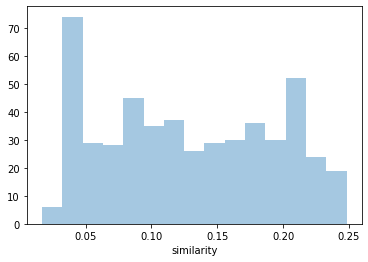

In [466]:
sns.distplot(random_samples_low.similarity, kde=False, bins=15)
plt.show()

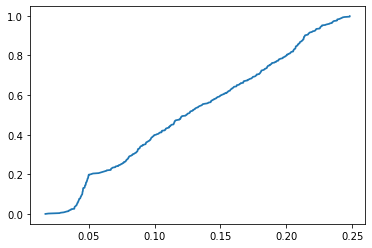

In [467]:
plot_cumulative_dist(random_samples_low.similarity.values)
plt.show()

### 2.2.2 Higher-similarity transitions

In [468]:
bins = np.linspace(0.25,1,20)
bins = np.append(bins[0:-8],[1.01])

random_samples_high = get_samples_from_intervals(bins, N_HIGHER, random_seed=6666)

0.25..0.29[n=316]
0.29..0.33[n=316]
0.33..0.37[n=316]
0.37..0.41[n=316]
0.41..0.45[n=316]
0.45..0.49[n=316]
0.49..0.53[n=316]
0.53..0.57[n=316]
0.57..0.61[n=316]
0.61..0.64[n=316]
0.64..0.68[n=316]
0.68..1.01[n=324]
END


In [469]:
N_SAMPLE = int(N_HIGHER / (len(bins)-1))
np.random.seed(6666)
random_states = [np.random.randint(100000) for j in range(len(bins))]

random_samples = pd.DataFrame()

N_Total = 0
for b in range(len(bins)-1):
    print(f'{b}..', end='')
    if b == (len(bins)-2):
        N_SAMPLE = N_HIGHER - N_Total
    random_sample = get_transitions_dataframe((W >= bins[b]) & (W < bins[b+1]) & not_self)
    random_sample = get_and_check_random_sample(random_sample, N_SAMPLE, random_state=random_states[b])
    random_samples = random_samples.append(random_sample, ignore_index=True)
    N_Total += N_SAMPLE
random_samples = get_similarity_values(random_samples)    

0..1..2..3..4..5..6..7..8..9..10..11..

In [470]:
random_samples_high = random_samples.copy()

In [471]:
len(random_samples_high)

3800

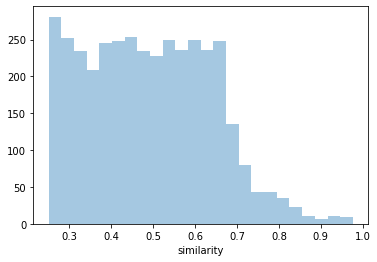

In [472]:
sns.distplot(random_samples_high.similarity, kde=False)
plt.show()

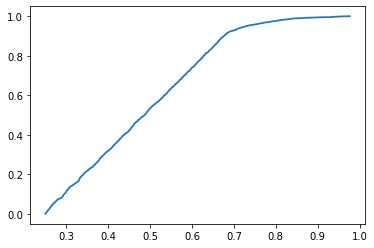

In [473]:
plot_cumulative_dist(random_samples_high.similarity.values)
plt.show()

### 2.2.3 Join up both ranges and export

In [474]:
random_samples_all = random_samples_high.append(random_samples_low, ignore_index=True)
random_samples_all = random_samples_all.sort_values('similarity')

In [475]:
# Semantic similarity threshold below which we call the pairwise skill match a skills gap (i.e. "unmatched")
MATCH_THRESHOLD = 0.80 
# Max number of matched skills or "unmatched" skills gaps
N_MAX = 10
# Output file name
file_name = 'Transitions_for_1715_BATCH_2.csv'
# Test mode generates a couple of transitions
TEST_MODE = False


In [476]:
outputs_uniform = get_transition_skills(random_samples_all, TEST_MODE, MATCH_THRESHOLD, N_MAX)

### Sanity check

In [487]:
def check_similarity(df):
    similarities = []
    for j, row in df.iterrows():
        similarities.append(sim.W_combined[row.origin_id, row.destination_id])
    df_ = df.copy()
    df_['similarity2'] = similarities
    assert(np.sum(np.abs(df_['similarity2'] - df_['similarity']))==0)
    return df_

In [488]:
df = check_unmatched_skills(outputs_uniform)
print(len(df[df.n_wrong!=0]))
len(df[df.n_wrong==0]) == len(df)

0


True

In [489]:
_ = check_similarity(outputs_uniform)

In [497]:
output_df_sample = outputs_uniform.loc[np.random.randint(len(outputs_uniform))]
output_df_sample

origin_id                                                                2195
origin_label                                                    veneer grader
origin_description          Veneer graders inspect slices of veneer for qu...
destination_id                                                           2085
destination_label                                  product quality controller
destination_description     Product quality controllers check the quality ...
perfectly_matched_skills    monitor manufacturing quality standards; revis...
partially_matched_skills    quality assurance procedures; perform quality ...
unmatched_skills            manage health and safety standards; support im...
similarity                                                           0.488565
Name: 2417, dtype: object

In [498]:
print(output_df_sample.perfectly_matched_skills.split(';'))
print('---')
print(output_df_sample.partially_matched_skills.split(';'))
print('---')
print(output_df_sample.unmatched_skills.split(';'))

['monitor manufacturing quality standards', ' revise quality control systems documentation', ' quality standards', ' oversee quality control']
---
['quality assurance procedures', ' perform quality audits', ' track key performance indicators', ' check quality of products on the production line']
---
['manage health and safety standards', ' support implementation of quality management systems', ' monitor the production line', ' write inspection reports', ' work in assembly line teams', ' define quality standards', ' quality control systems']


In [499]:
trans_utils.show_skills_overlap(output_df_sample.origin_id,
                                output_df_sample.destination_id,
                                data, sim,
                                embeddings,
                                skills_match='optional',
                                verbose=True)


from veneer grader to product quality controller
--------
15/15 destination skills matched
NLP-adjusted overlap = 0.36 (total combined similarity: 0.49)


,origin_skill_id,origin_skill,destination_skill_id,destination_skill,similarity,score
0,3353,monitor manufacturing quality standards,3353,monitor manufacturing quality standards,1.000000,0.998
1,5765,revise quality control systems documentation,5765,revise quality control systems documentation,1.000000,0.998
2,7508,quality standards,7508,quality standards,1.000000,0.998
3,4966,oversee quality control,4966,oversee quality control,1.000000,0.998
4,10526,quality assurance methodologies,910,quality assurance procedures,0.890035,0.731
5,1831,set quality assurance objectives,11376,perform quality audits,0.860425,0.383
6,4657,meet contract specifications,7529,track key performance indicators,0.845662,0.228
7,2165,record production data for quality control,4957,check quality of products on the production line,0.817411,0.067
8,10151,recommend product improvements,11232,quality control systems,0.794928,0.023
9,160,create solutions to problems,4991,define quality standards,0.783847,0.013


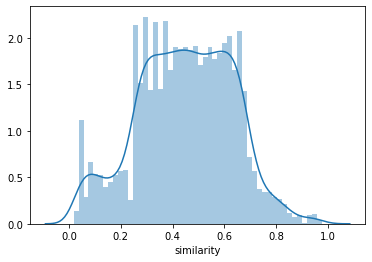

In [500]:
sns.distplot(outputs_uniform.similarity, bins=50)

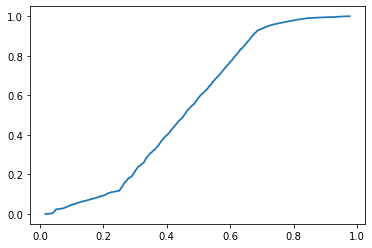

In [501]:
plot_cumulative_dist(outputs_uniform.similarity.values)
plt.show()

In [502]:
outputs_uniform.sample()

,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,unmatched_skills,similarity
1417,867,bindery operator,Bindery operators tend machines that bind prin...,2394,glass beveller,"Glass bevellers measure, cut, assemble and ins...",monitor automated machines; ensure equipment a...,monitor gauge; consult technical resources; me...,manipulate glass; cut glass; adjust glass shee...,0.363908


### Export!

In [503]:
outputs_uniform_to_export = outputs_uniform.drop('similarity', axis=1)
outputs_uniform_to_export.to_csv(outputs_folder + file_name, index=False)
